[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/soloyant/deltax_workshop_2024/blob/main/tutorials/1_HydrodynamicModeling_ANUGA/[1]ANUGA_DEM_processing.ipynb)

<div style="text-align: center;">
    <img src="notebook_illustrations/deltax_2020.png" alt="Delta-X Logo" style="height: 100px; width: auto; display: inline;">
    <img src="notebook_illustrations/Tribrand_ColorBlack_rgb_16x3_160601.png" alt="JPL Logo" style="height: 100px; width: auto; display: inline;">
</div>
<h1 style="text-align: center;">Delta-X 2024 Application Workshop - May 8, 2024</h1>
<h2 style="text-align: center;">Anuga Hydrodynamic Modeling: Hands On Exercises</h2>
<h2 style="text-align: center;">Part 1/5: DEM Processing</h2>

<h3>Author information:</h3>

**Antoine Soloy, Ph.D.**  
Division 334F, Caltech - Jet Propulsion Laboratory  
4800 Oak Grove Drive, Pasadena, CA, USA  91109-8099  
Contact: antoine.soloy@jpl.nasa.gov

<h3>Notebook Description:</h3>

The present notebook is the first one in a series of five on how to use the ANUGA hydrodynamic model to generate simple simulations of coastal esturarine systems, including:  
- [1]ANUGA_DEM_preprocessing.ipynb : Modifications to the Digital Elevation Model to optimize hydrological connectivity.  
- [2]ANUGA_friction_map_generation.ipynb : Generation of a land & water classification map for friction calibration purpose.
- [3]ANUGA_model_run.ipynb : Setting up of the hydrodynamic model and run.
- [4]ANUGA_output_analysis.ipynb : Output reading and generation of animations
- [5]ANUGA_model_validation.ipynb : Comparison between in-situ/remote sensing data and model predictions

<h3>Necessary Datasets:</h3>

Please ensure that all the following datasets were downloaded and placed into the "data" subfolder. Zip files should be unziped in the same folder, keeping the original tree structure intact.

<h4>Delta-X Digital Elevation Model (DEM) and Water Mask</h4>

- Download link: https://doi.org/10.3334/ORNLDAAC/2181  
- Citation: Christensen, A.L., M.W. Denbina, and M. Simard. 2023. Delta-X: Digital Elevation Model, MRD, LA, USA, 2021. ORNL DAAC, Oak Ridge, Tennessee, USA. https://doi.org/10.3334/ORNLDAAC/2181  

<h4>Delta-X Vegetation Classification Map</h4>

- Download link: https://drive.google.com/file/d/1OSyAWekAuXGFz3yLRz61PlLuQgj2FkGa/view?usp=drive_link  
- Citation: Jensen, D.J., E. CastaÃƒÂ±eda-Moya, E. Solohin, D.R. Thompson, and M. Simard. 2024. Delta-X AVIRIS-NG L3 Derived Vegetation Types, MRD, Louisiana, USA. ORNL DAAC, Oak Ridge, Tennessee, USA. https://doi.org/10.3334/ORNLDAAC/2352  

<h4>Delta-X AirSWOT L3 Water Surface Elevations</h4>

- Download link: https://doi.org/10.3334/ORNLDAAC/2349  
- Citation: Denbina, M.W., M. Simard, and E. Rodriguez. 2024. Delta-X: AirSWOT L3 Water Surface Elevations, MRD, Louisiana, 2021, V2. ORNL DAAC, Oak Ridge, Tennessee, USA. https://doi.org/10.3334/ORNLDAAC/2349  

<h4>JPL Mississippi River Centerlines</h4>

- Download link: https://landscape.jpl.nasa.gov/cgi-bin/data-search.pl  
- Citation: Christensen, A.L., Soloy, A., Savelli, R., Moritz, J.M., & Simard, M. (2023b). Centerlines of the Mississippi River (V1.0) [Data file]. Retrieved from https://landscape.jpl.nasa.gov/cgi-bin/data-search.pl  

<h4>CRMS water level gauges</h4>

- Download link: https://drive.google.com/file/d/18qINc-Xpus0g7cvsQT-BzH9KWgC35rFU/view?usp=drive_link (workshop sample)
- Citation: Coastal Protection and Restoration Authority (CPRA) of Louisiana. 2024. Coastwide Reference Monitoring System-Wetlands Monitoring Data. Retrieved from Coastal Information Management System (CIMS) database. http://cims.coastal.louisiana.gov. Accessed 24 January 2024



## I - Import packages and define the working directories

In [1]:
import sys

if 'google.colab' in sys.modules:
  # In case the notebook is opened in google collab, here we download/install all the files we need behind the scenes
  try:
      import os
      os.chdir('/content')
      # Grab workbook files into colab directory
      !git clone https://github.com/soloyant/deltax_workshop_2024.git
      # Install everything using some bash scripts
      !/bin/bash /content/deltax_workshop_2024/tutorials/1_HydrodynamicModeling_ANUGA/utils/anuga_tools/install_anuga_colab.sh
      os.chdir('/content/deltax_workshop_2024/tutorials/1_HydrodynamicModeling_ANUGA/')
  except:
      pass

In [2]:
import pandas as pd
import geopandas as gpd
import rasterio as rio
import numpy as np
import os
from scipy import ndimage
import matplotlib.pyplot as plt
import cmocean
import shutil
from pathlib import Path
from tqdm import notebook
from utils import data_processing_tools as dpt

# Define the path to scripts and data
workshop_dir = os.getcwd()
# # Alternatively:
# workshop_dir = '/path/to/1_HydrodynamicModeling_ANUGA'
data_dir = os.path.join(workshop_dir, 'data')
model_inputs_dir = os.path.join(workshop_dir, 'model_inputs')
model_outputs_dir = os.path.join(workshop_dir, 'model_outputs')
if 'google.colab' in sys.modules:
    data_dir = os.path.join(data_dir, 'collab')
    model_inputs_dir = os.path.join(model_inputs_dir, 'collab')
    model_outputs_dir = os.path.join(model_outputs_dir, 'collab')
model_visuals_dir = os.path.join(workshop_dir, 'visuals')
model_validation_dir = os.path.join(workshop_dir, 'validation')

for d in [model_inputs_dir, model_outputs_dir, model_visuals_dir, model_validation_dir]:
    Path(d).mkdir(parents=True, exist_ok=True)
        

## II - Domain definition

Let us draw the external boundaries of our model domain considering all applicable constrains (i.e., watershed isolation, data availability, computational limitations, etc.).  
To do this, **run the next cell**, then **select the polygon tool** on the left pannel and **draw a polygon** delimiting your region of interest.  
**Clic on "Save Coordinates"** at the bottom left of the map to save the result.


In [3]:
f_domain = os.path.join(data_dir, 'dxws_domain.shp')
epsg=32615
if 'google.colab' not in sys.modules:
    dpt.draw_polygon(filename=f_domain, epsg=epsg)

Map(center=[29.5, -91.3], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

Button(description='Save to Shapefile', style=ButtonStyle())

Output()

## III - DEM clipping

To optimize the modeling workflow, we will clip our Digital Elevation Model (DEM) using the freshly drawn polygon and apply all the necessary file type conversions.

In [4]:
## Import the datasets

# Domain
domain_gdf = gpd.read_file(f_domain)

# DEM
f_DEM_tif = os.path.join(data_dir, 'DeltaX_MultiSource_DEM_Atchafalaya-Terrebonne_Basin_2021_V1.tif')
if 'google.colab' not in sys.modules:
    DEM_src = rio.open(f_DEM_tif)
    DEM = DEM_src.read(1)
    resolution = DEM_src.res[0]

# Background imagery
f_bg_img_tif = os.path.join(data_dir, 'misissippi_S2_background_image.tif')
bg_img_src = rio.open(f_bg_img_tif)
bg_img = np.stack([bg_img_src.read(i) for i in range(1, bg_img_src.count+1)], axis=2)
bg_img_extent = [bg_img_src.bounds.left, bg_img_src.bounds.right,
                 bg_img_src.bounds.bottom, bg_img_src.bounds.top]

To avoid any aliasing/extraction artifacts, we first need to buffer the domain by a few times the resolution of the DEM, and then apply the clipping process.

In [5]:
# Buffer domain polygon
f_clipper_line_buffered = f_domain.replace('.shp', '_buffered.shp')
if 'google.colab' not in sys.modules:
    dpt.createBuffer(f_domain, f_clipper_line_buffered, 10*resolution)

# Clip DEM with buffered domain polygon
f_DEM_clipped_tif = f_DEM_tif.replace('.tif', '_clipped.tif')
if 'google.colab' not in sys.modules:
    !gdalwarp -cutline $f_clipper_line_buffered -crop_to_cutline $f_DEM_tif $f_DEM_clipped_tif -dstnodata -9999 -overwrite


/opt/anaconda3/envs/anuga_dx/lib/python3.9/site-packages/osgeo/ogr.py:593: FutureWarning: Neither ogr.UseExceptions() nor ogr.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


Creating output file that is 2748P x 2920L.
Processing /Users/soloy/Documents/GitHub/deltax_workshop_2024/tutorials/1_HydrodynamicModeling_ANUGA/data/DeltaX_MultiSource_DEM_Atchafalaya-Terrebonne_Basin_2021_V1.tif [1/1] : 0Warning 1: the source raster dataset has a SRS, but the cutline features
not.  We assume that the cutline coordinates are expressed in the destination SRS.
If not, cutline results may be incorrect.
...10...20...30...40...50...60...70...80...90...100 - done.


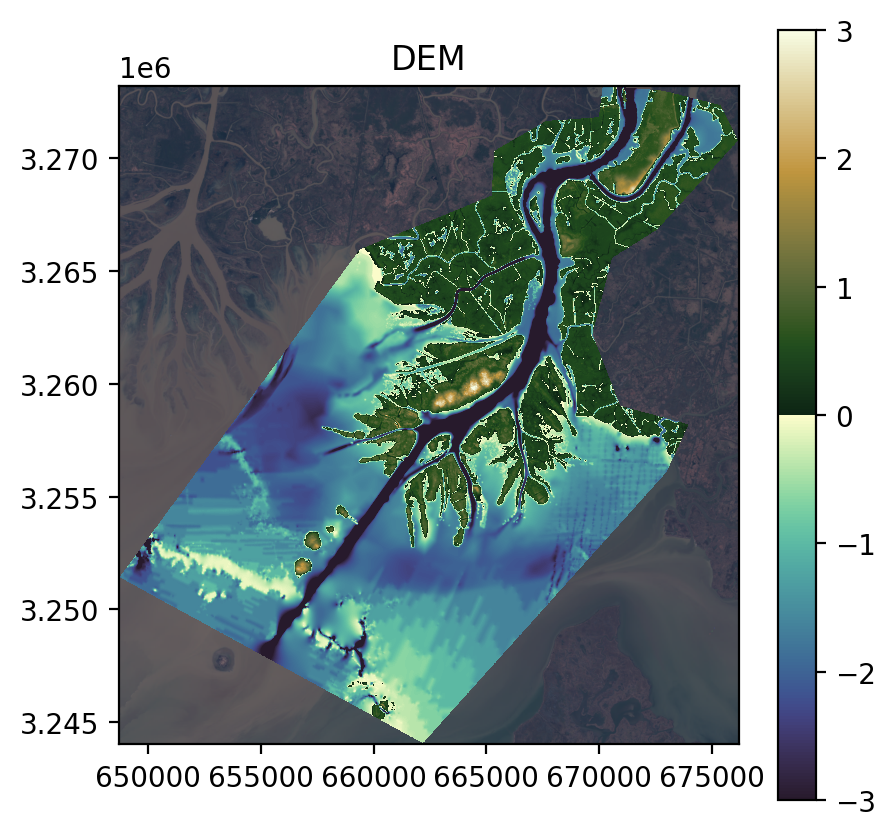

In [6]:
# Import and load freshly clipped DEM
DEM_src = rio.open(f_DEM_clipped_tif)
extent = [DEM_src.bounds.left, DEM_src.bounds.right,
          DEM_src.bounds.bottom, DEM_src.bounds.top]
DEM = DEM_src.read(1)
resolution = DEM_src.res[0]
DEM_no_data = DEM_src.nodatavals[0]
if DEM_no_data is not None:
    DEM = np.where(DEM == DEM_no_data, np.nan, DEM)

# Data visualization
fig, ax = plt.subplots(1,1, figsize=(5, 5), dpi=200)

ax.imshow(bg_img, extent=bg_img_extent)
im1 = ax.imshow(DEM, cmap='cmo.topo', vmin=-3, vmax=3, extent=extent)
ax.set_title('DEM')
plt.colorbar(im1)

plt.savefig(os.path.join(model_visuals_dir, 'DEM.png'))
plt.show()

## IV - Channel carving

Large scale DEMs are often imprecise regarding smaller scale features. This is especially true for morphologically complex and vegetated regions such as the Mississippi River Delta. Despite encompassing a large amount of data from various sources, the DEM generated in the framework of the Delta-X Mission is not exempt of such issues and unfortunately lacks some channels and islands, thereby limiting the hydrological conectivity of the system.  
To partially overcome this problem and ensure an optimal connectivity in the river network, we will use the global dataset of river delta centerlines published by JPL and artificially carve the channels that may not appear in the original DEM.  
The proposed methodology is the following: (1) Pre-proecess the centerlines, (2) Convert them into polygons, then rasterize the polygons (3) Use the raster to compute artificial channel profiles, and (4) For each pixel, keep the minimum depth value between the original and the artificial DEMs.  
First, please **download the Mississippi River centerlines** at *https://landscape.jpl.nasa.gov/cgi-bin/data-search.pl*, unzip the file and place it in the workshop data directory. Then, let us **run the next cells**.

### 1 - Pre-processing

In [7]:
# Define file paths
f_centerlines_shp = os.path.join(data_dir, 'mississippi_River_Centerlines_V1/mississippi_River_Centerlines_V1.shp')
f_centerlines_buffered_shp = f_centerlines_shp.replace('.shp', '_buffered.shp')
f_centerlines_buffered_tif = f_centerlines_buffered_shp.replace('.shp', '.tif')

# Read and format centerline dataset
centerlines_gdf = gpd.read_file(f_centerlines_shp).to_crs(epsg=epsg)

# Resample the centerlines using a regular footstep
centerlines_gdf = dpt.resample_gdf(centerlines_gdf, d=50)

# Remove all centerlines located out of our model domain
centerlines_gdf = centerlines_gdf.overlay(gpd.GeoDataFrame(geometry=[domain_gdf.buffer(resolution*10).geometry[0]]))

The water mask provided with the DEM dataset will be used to estimate the channel width, using a distance transform operation.

Creating output file that is 2748P x 2920L.
Processing /Users/soloy/Documents/GitHub/deltax_workshop_2024/tutorials/1_HydrodynamicModeling_ANUGA/data/DeltaX_MultiSource_DEM_watermask_V1.tif [1/1] : 0Warning 1: the source raster dataset has a SRS, but the cutline features
not.  We assume that the cutline coordinates are expressed in the destination SRS.
If not, cutline results may be incorrect.
...10...20...30...40...50...60...70...80...90...100 - done.


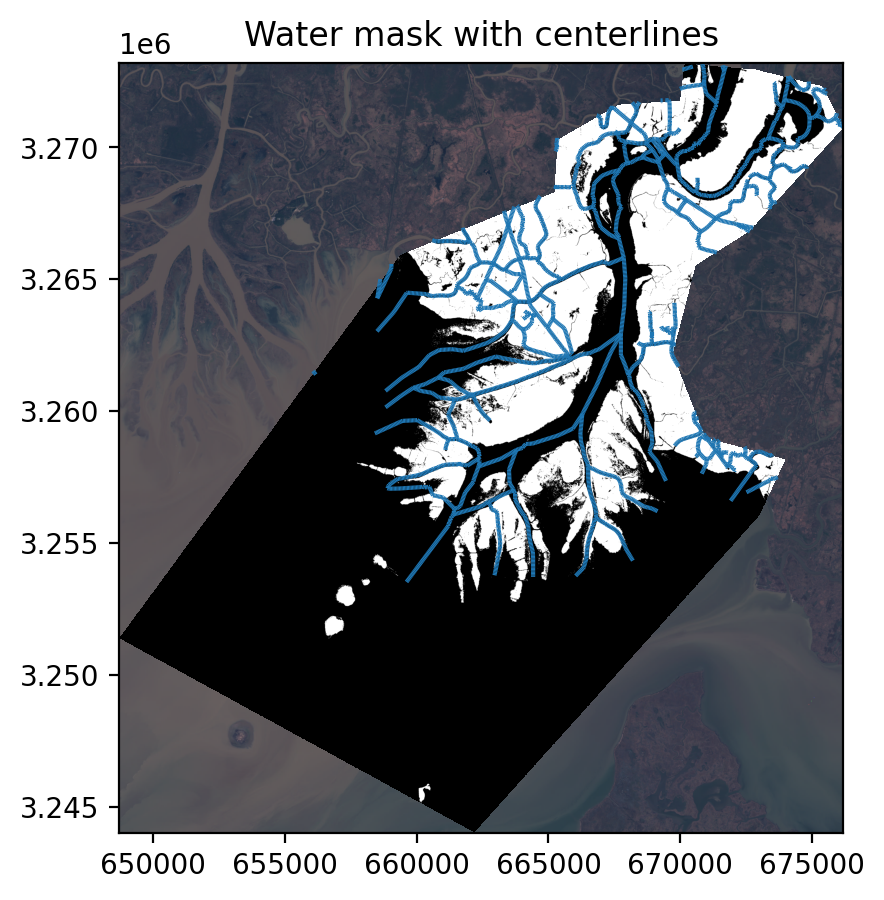

In [8]:
# Load water mask
f_water_mask_tif = os.path.join(data_dir, 'DeltaX_MultiSource_DEM_watermask_V1.tif')
if 'google.colab' not in sys.modules:
    water_mask_src = rio.open(f_water_mask_tif)
    water_mask = water_mask_src.read(1)

# Clipping DEM with buffered domain polygon
f_water_mask_clipped_tif = f_water_mask_tif.replace('.tif', '_clipped.tif')
if 'google.colab' not in sys.modules:
    !gdalwarp -cutline $f_clipper_line_buffered -crop_to_cutline $f_water_mask_tif $f_water_mask_clipped_tif -dstnodata -9999 -overwrite

# Load clipped water mask
water_mask_src = rio.open(f_water_mask_clipped_tif)
water_mask = water_mask_src.read(1)

water_mask_no_data = water_mask_src.nodatavals[0]
if water_mask_no_data is not None:
    water_mask = np.where(water_mask == water_mask_no_data, np.nan, water_mask)

# Compute distance to water line
water_mask_dist = ndimage.distance_transform_edt(water_mask)

fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)
ax.imshow(bg_img, extent=bg_img_extent)
ax.imshow(water_mask, extent=extent, vmin=0, vmax=1, cmap='binary')
centerlines_gdf.plot(ax=ax)
ax.set_xlim(extent[0:2])
ax.set_ylim(extent[2:])
ax.set_title('Water mask with centerlines')

plt.savefig(os.path.join(model_visuals_dir, 'watermask_with_centerlines.png'))
plt.show()

### 2 - Polygonize and Rasterize centerlines

This step allows us to define the *min_width* value at which all small channels will be enlarged. This can be useful when the resolution of the model mesh is limited in order to enforce connectivity in the system. We will also cap the carving to widths narrower than a *max_width* threshold in order to avoid overcarving the large features.  
Variables *maxdepth* and *bank_slope_proxy* will be used to controle the morphology of the artificial channel profiles in the later steps.

In [9]:
# Define the parameters for DEM carving

min_width = 100        # All narrower channels will be enlarged up to this value (in meters)
max_width = 250       # Maximum range of modifiable pixels from centerlines
maxdepth = -3         # Maximum river carving depth
bank_slope_proxy = 50  #]0 to inf[, lower numbers result in steeper bank slopes

In [10]:
# Measure the missing widths from water mask
centerlines_gdf['width_m'] = 0
for j in notebook.tqdm(range(len(centerlines_gdf))):
    extraction_coords = np.asarray(centerlines_gdf.iloc[j].geometry.centroid.xy)
    extraction_rows, extraction_cols = water_mask_src.index(extraction_coords[0], extraction_coords[1])
    try:
        # Extracted values correspond to half the width (distance between bank and centerlines)
        centerlines_gdf.loc[j, 'width_m'] = water_mask_dist[extraction_rows[0], extraction_cols[0]]*resolution*2
    except:
        centerlines_gdf.loc[j, 'width_m'] = np.nan

# Remove all centerlines located out of our model domain
centerlines_gdf = centerlines_gdf.dropna().reset_index(drop=True)

# We assume that centerlines with width=0 correspond to channels narrower or as narrow as the data resolution
centerlines_gdf.loc[centerlines_gdf['width_m']<min_width, 'width_m'] = min_width

# Set a threshold to the max width to prevent overestimations and overcarving 
centerlines_gdf.loc[centerlines_gdf['width_m']>max_width, 'width_m'] = max_width

  0%|          | 0/4643 [00:00<?, ?it/s]

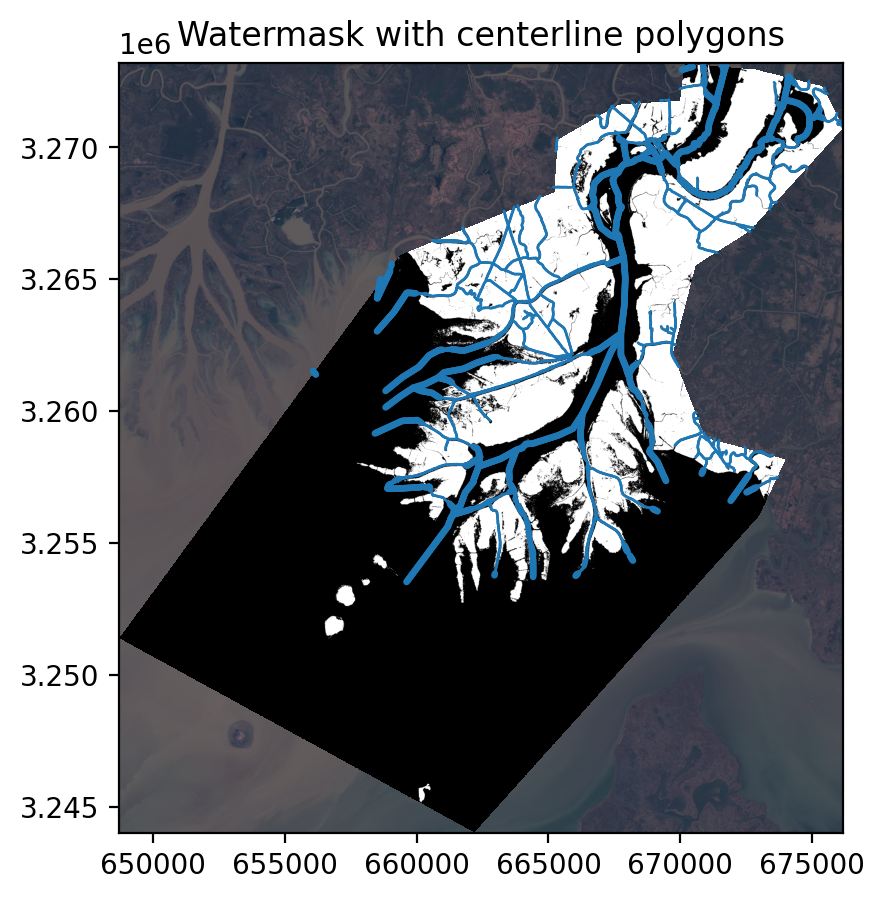

In [11]:
# Buffer centerlines with their width
centerlines_gdf['geometry'] = centerlines_gdf['geometry'].buffer(centerlines_gdf['width_m']/2)
centerlines_gdf.to_file(f_centerlines_buffered_shp)

# Data visualization
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi= 200)
ax.imshow(bg_img, extent=bg_img_extent)
ax.imshow(water_mask, extent=extent, vmin=0, vmax=1, cmap='binary')
centerlines_gdf.plot(ax=ax)
ax.set_xlim(extent[0:2])
ax.set_ylim(extent[2:])
ax.set_title('Watermask with centerline polygons')

plt.savefig(os.path.join(model_visuals_dir, 'watermask_with_centerlines_polygons.png'))
plt.show()

In [12]:
# Rasterize buffered vector of river centerlines
te = str(extent[0])+' '+str(extent[2])+' '+str(extent[1])+' '+str(extent[3])
!gdal_rasterize -burn 1 -tr $resolution $resolution -te $te -ot Int32 -of GTiff $f_centerlines_buffered_shp $f_centerlines_buffered_tif

# Ensure that the new centerlines raster is aligned with the other data
dpt.reproj_match(infile = f_centerlines_buffered_tif, 
             match = f_DEM_clipped_tif, 
             outfile = f_centerlines_buffered_tif)

0...10...20...30...40...50...60...70...80...90...100 - done.


### 3 - Compute artificial channel profiles

A hyperbolic tangent function is used to generate the U shape of channel profiles. 

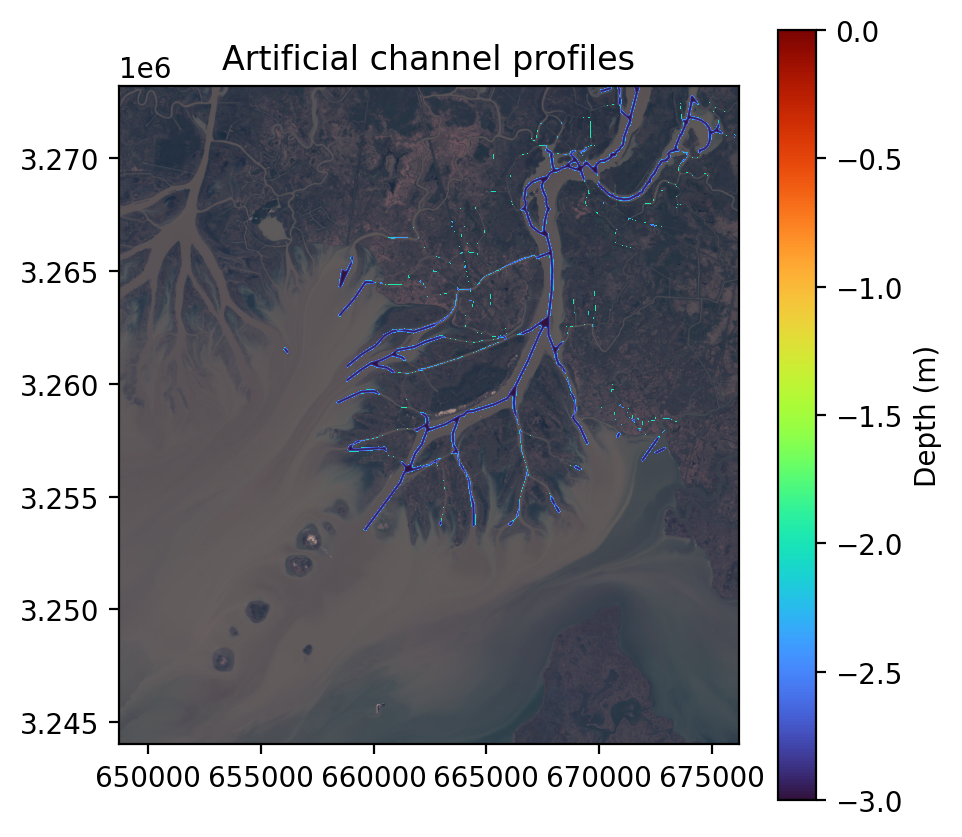

In [13]:
# Load centerlines raster and calculate a parametric DEM
centerlines_water_mask_src = rio.open(f_centerlines_buffered_tif)
centerlines_water_mask = centerlines_water_mask_src.read(1)

centerlines_water_mask_dist = ndimage.distance_transform_edt(centerlines_water_mask)

centerlines_parametric_DEM = np.tanh((centerlines_water_mask_dist*resolution)/bank_slope_proxy) * maxdepth * centerlines_water_mask 
centerlines_parametric_DEM[centerlines_parametric_DEM==0]=np.nan

fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)
ax.imshow(bg_img, extent=bg_img_extent)
im = ax.imshow(centerlines_parametric_DEM, extent=extent, cmap='turbo', vmin=maxdepth, vmax=0)
plt.colorbar(im, label='Depth (m)')
ax.set_title('Artificial channel profiles')

plt.savefig(os.path.join(model_visuals_dir, 'artificial_channels.png'))
plt.show()

### 4 - Combine DEMs

/var/folders/1d/t5vw320n66q_x4h2qkvrf6sw0000gq/T/ipykernel_37900/145615831.py:2: RuntimeWarning: All-NaN slice encountered
  edited_DEM = np.nanmin(np.concatenate([DEM.reshape((DEM.shape[0], DEM.shape[1], 1)),


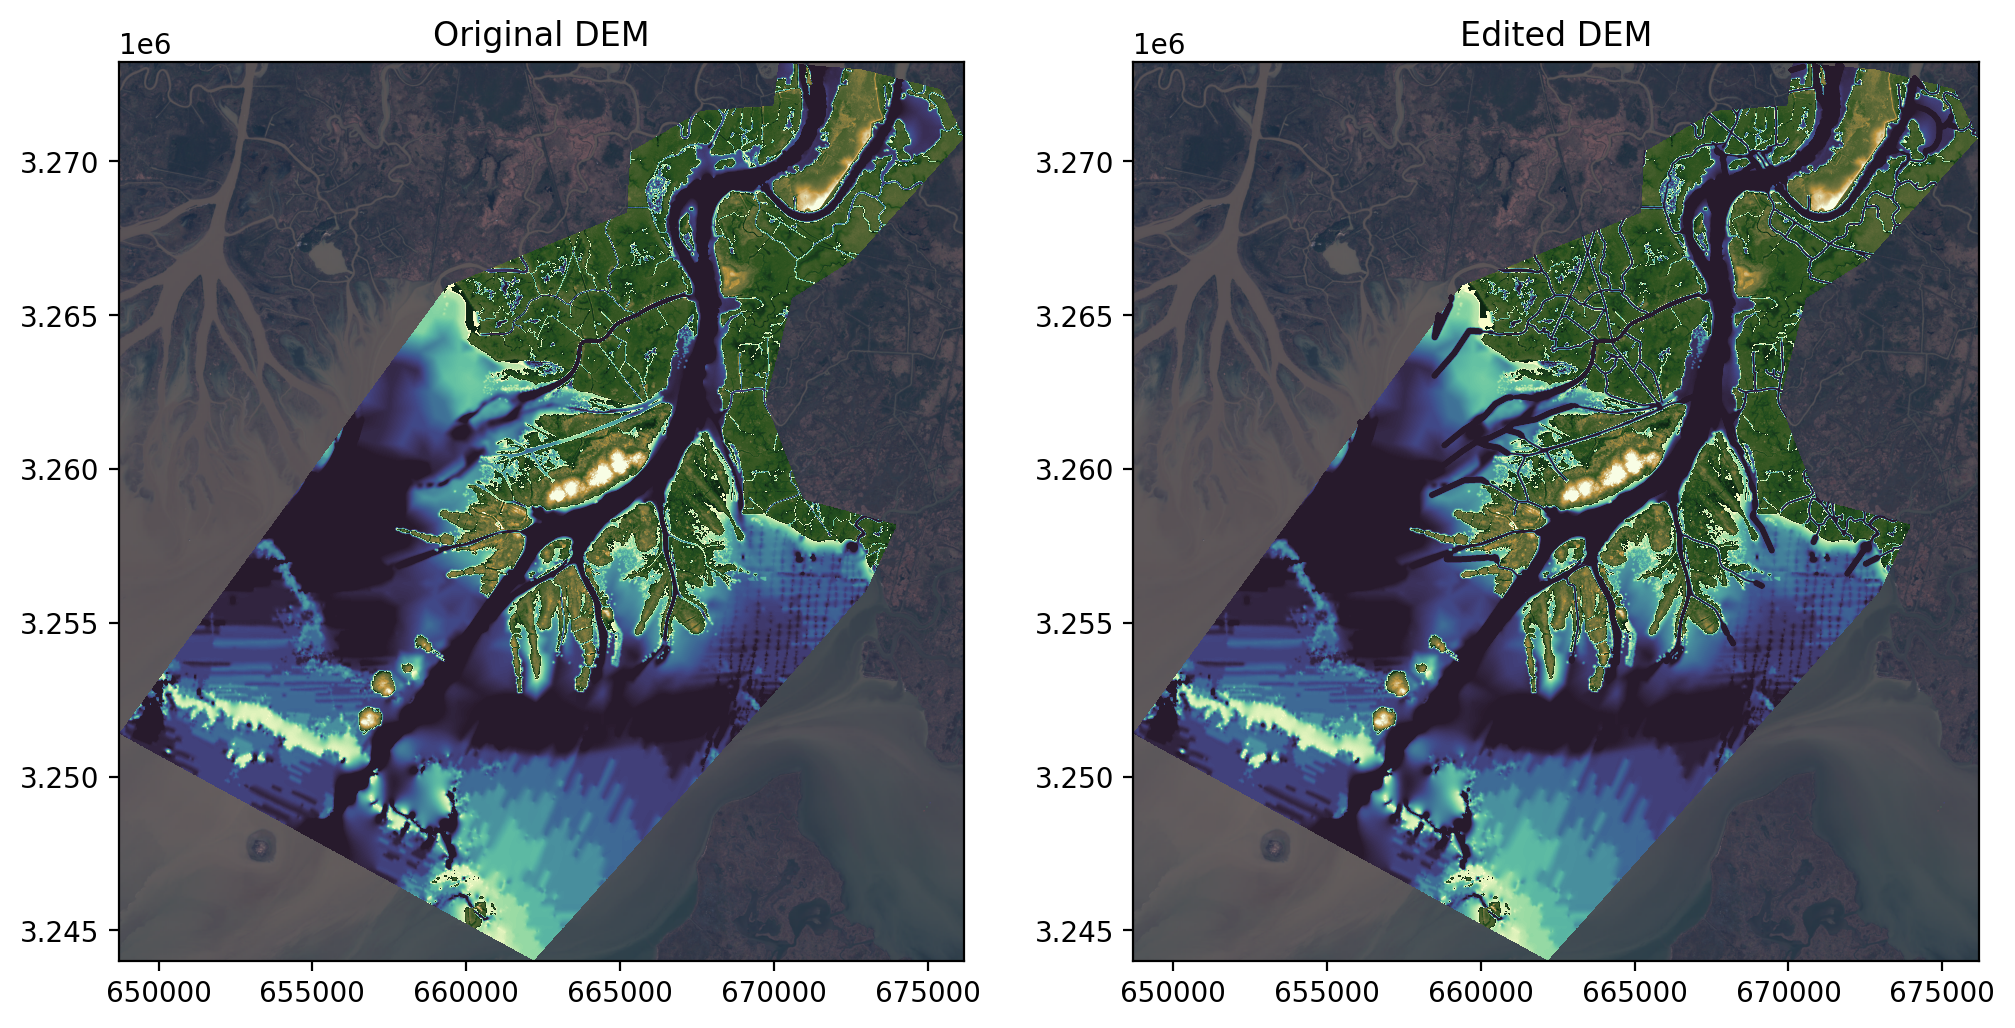

In [14]:
# For each pixel, only keep the min value between DEM and centerlines_parametric_DEM 
edited_DEM = np.nanmin(np.concatenate([DEM.reshape((DEM.shape[0], DEM.shape[1], 1)), 
                                       centerlines_parametric_DEM.reshape((centerlines_parametric_DEM.shape[0], centerlines_parametric_DEM.shape[1], 1))], axis=2), axis=2)

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6), dpi=200)
ax1.imshow(bg_img, extent=bg_img_extent)
ax1.imshow(DEM, extent=extent, cmap='cmo.topo', vmin=-2, vmax=2)
ax1.set_title('Original DEM')
ax2.imshow(bg_img, extent=bg_img_extent)
ax2.imshow(edited_DEM, extent=extent, cmap='cmo.topo', vmin=-2, vmax=2)
ax2.set_title('Edited DEM')

plt.savefig(os.path.join(model_visuals_dir, 'original_vs_modified_DEM.png'))
plt.show()

# Ensure the result remains within domain boundaries
edited_DEM[np.isnan(DEM)] = -9999

## V - Saving the results

Anuga requires the DEM to be provided as an ascii file.

In [15]:
f_edited_DEM_asc = os.path.join(model_inputs_dir, f_DEM_tif.split('/')[-1].replace('.tif', '_edited.asc'))

if os.path.exists(f_edited_DEM_asc): # rasterio doesn't like erasing existing ascii files
    os.remove(f_edited_DEM_asc)

with rio.open(f_edited_DEM_asc, 'w', driver='AAIGrid', 
              height=centerlines_water_mask_src.height, width=centerlines_water_mask_src.width, count=1, dtype=edited_DEM.dtype, 
              crs=epsg, transform=centerlines_water_mask_src.transform, compress="LZW", nodata=-9999) as raster_file:
    raster_file.write(edited_DEM, 1)
    

Now we can delete intermediary files.

In [16]:
list_of_files_to_delete = [f_clipper_line_buffered,
                           f_centerlines_buffered_shp]

for file in list_of_files_to_delete:
    if os.path.exists(file): 
        if os.path.isfile(file):
            os.remove(file)
            if file.endswith('shp'):
                try:
                    os.remove(file.replace('.shp', '.shx'))
                    os.remove(file.replace('.shp', '.dbf'))
                    os.remove(file.replace('.shp', '.cpg'))
                    os.remove(file.replace('.shp', '.prj'))
                except:
                    pass
        else:
            shutil.rmtree(file)